In [1]:
import pandas as pd

data = []

for x in range(1, 11):
  df = pd.read_csv(f"/content/drive/MyDrive/Colab Notebooks/mHealth_subject{x}.log", sep = r'\s+', header=None)

  # 3. 마지막 열을 'label'로 지정하고 나머지는 feature
  feature_cols = [f"feature_{i}" for i in range(1, df.shape[1])]  # 마지막 열 제외
  df.columns = feature_cols + ["label"]

  # 레이블 0 드롭
  df.drop(df[df['label'] == 0].index, inplace=True)


  # 5. 결과 확인
  # print(df.head())
  print(df['label'].value_counts())
  data.append(df)

label
8     3379
1     3072
3     3072
2     3072
4     3072
6     3072
7     3072
9     3072
10    3072
11    3072
5     3072
12    1075
Name: count, dtype: int64
label
8     3430
7     3328
6     3174
5     3072
3     3072
2     3072
1     3072
4     3072
10    3072
11    3072
9     3072
12    1024
Name: count, dtype: int64
label
7     3379
6     3226
8     3175
1     3072
4     3072
3     3072
2     3072
9     3072
10    3072
11    3072
5     3072
12    1024
Name: count, dtype: int64
label
6     3328
7     3277
8     3123
5     3072
3     3072
2     3072
1     3072
4     3072
9     3072
10    3072
11    3072
12    1024
Name: count, dtype: int64
label
1     3072
2     3072
3     3072
4     3072
9     3072
5     3072
11    3072
10    3072
7     2868
6     2765
8     2714
12    1024
Name: count, dtype: int64
label
1     3072
2     3072
3     3072
4     3072
9     3072
5     3072
11    3072
10    3072
8     2304
6     2202
7     2099
12    1024
Name: count, dtype: int64
label
5     3072

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd


In [3]:
# label 제외
features = df.drop('label', axis=1)
labels = df['label']


In [4]:
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

df_scaled = pd.DataFrame(scaled_features, columns=features.columns)
df_scaled['label'] = labels.values

In [5]:
data

[        feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
 6656      -9.7788    0.55690    1.19750   0.008373  -0.033490     2.6493   
 6657      -9.7733    0.27880    0.73036  -0.025118  -0.025118     2.4157   
 6658      -9.8609    0.11561    0.79988   0.025118   0.016745     2.3865   
 6659      -9.7409    0.17652    0.88957   0.180010   0.129770     2.3758   
 6660      -9.7821    0.21637    0.90368   0.092098   0.046049     2.3239   
 ...           ...        ...        ...        ...        ...        ...   
 160251    -7.8711    0.62612   -2.80680   0.037677   0.004186    -1.1274   
 160252    -7.2748    1.11390   -3.51030  -0.246990  -0.196760    -1.3928   
 160253    -7.5005    1.28830   -1.98930  -0.138150  -0.100470    -1.1938   
 160254    -7.0947    1.70440   -2.78340  -0.092098  -0.050235    -1.9781   
 160255    -7.2785    2.31010   -1.92890  -0.066981  -0.037677    -1.7048   
 
         feature_7  feature_8  feature_9  feature_10  ...  feature_15  \
 

In [6]:
# 1차 실행 버전(과적합)

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout, MaxPooling1D
from tensorflow.keras.utils import to_categorical

# 1️⃣ 데이터 분리
train_dfs = data[2:10]  # 3~10번
val_dfs = data[0:2]     # 1~2번

# 2️⃣ Train, Validation 통합
train_df = pd.concat(train_dfs, ignore_index=True)
val_df = pd.concat(val_dfs, ignore_index=True)

# 3️⃣ X, y 분리
X_train = train_df.drop('label', axis=1).values
y_train = train_df['label'].values
X_val = val_df.drop('label', axis=1).values
y_val = val_df['label'].values

# 4️⃣ 스케일링 (StandardScaler 예제)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# 5️⃣ CNN 입력 형태로 reshape
# Conv1D는 (samples, timesteps, features) 형태 필요
# MHEALTH 데이터의 경우 timesteps = 1, features = column 개수
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

y_train = y_train - 1
y_val = y_val - 1


# 6️⃣ 라벨을 One-hot encoding
num_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)

# 7️⃣ CNN 모델 구성
model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 8️⃣ 모델 학습
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
4258/4258 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.8173 - loss: 0.5454 - val_accuracy: 0.6455 - val_loss: 2.1099
Epoch 2/10
4258/4258 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9655 - loss: 0.1015 - val_accuracy: 0.5974 - val_loss: 2.9286
Epoch 3/10
4258/4258 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9766 - loss: 0.0705 - val_accuracy: 0.6338 - val_loss: 3.4153
Epoch 4/10
4258/4258 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9806 - loss: 0.0582 - val_accuracy: 0.6193 - val_loss: 3.6272
Epoch 5/10
4258/4258 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9838 - loss: 0.0494 - val_accuracy: 0.5850 - val_loss: 3.3564
Epoch 6/10
4258/4258 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9855 - loss: 0.0436 - val_accuracy: 0.5836 - val_loss: 4.3376
Epoch 7/10
4258/4258 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9871 - loss: 0.0384 - val_accuracy: 0.5915 - val_loss: 4.5946
Epoch 8/10
4258/4258 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9880 - loss: 0

In [7]:
# 2차 실행 버전(과적합 약간 개선)

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout, MaxPooling1D
from tensorflow.keras.utils import to_categorical

# 1️⃣ Sliding window 함수 정의
def create_sliding_windows(df, window_size=50, hop_size=25):
    X = []
    y = []
    features = df.drop('label', axis=1).values
    labels = df['label'].values
    for start in range(0, len(df) - window_size + 1, hop_size):
        end = start + window_size
        X.append(features[start:end])
        # 윈도우 내 label은 가장 마지막 값 기준
        y.append(labels[end-1])
    return np.array(X), np.array(y)

# 2️⃣ 데이터 분리
train_dfs = data[2:10]  # 3~10번
val_dfs = data[0:2]     # 1~2번

train_df = pd.concat(train_dfs, ignore_index=True)
val_df = pd.concat(val_dfs, ignore_index=True)

# 3️⃣ Sliding window 적용
window_size = 50
hop_size = 25

X_train, y_train = create_sliding_windows(train_df, window_size, hop_size)
X_val, y_val = create_sliding_windows(val_df, window_size, hop_size)

# 4️⃣ 스케일링
scaler = StandardScaler()
# Conv1D expects 3D input: (samples, timesteps, features)
num_features = X_train.shape[2]
X_train = X_train.reshape(-1, num_features)
X_val = X_val.reshape(-1, num_features)

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

X_train = X_train.reshape(-1, window_size, num_features)
X_val = X_val.reshape(-1, window_size, num_features)

# 5️⃣ 라벨 0부터 시작
y_train -= 1
y_val -= 1

num_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)

# 6️⃣ CNN 모델 구성
model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', padding='same', input_shape=(window_size, num_features)),
    MaxPooling1D(pool_size=2),
    Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 7️⃣ 모델 학습
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1
)


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


171/171 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.4872 - loss: 1.5399 - val_accuracy: 0.7071 - val_loss: 1.0567
Epoch 2/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8957 - loss: 0.3758 - val_accuracy: 0.7329 - val_loss: 1.0474
Epoch 3/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9530 - loss: 0.1941 - val_accuracy: 0.7619 - val_loss: 1.2575
Epoch 4/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9653 - loss: 0.1457 - val_accuracy: 0.7138 - val_loss: 1.3010
Epoch 5/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9770 - loss: 0.1111 - val_accuracy: 0.7694 - val_loss: 1.3028
Epoch 6/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9781 - loss: 0.0952 - val_accuracy: 0.7602 - val_loss: 1.5011
Epoch 7/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9822 - loss: 0.0726 - val_accuracy: 0.7672 - val_loss: 1.6283
Epoch 8/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9824 - loss: 0.0706 - val_accuracy: 0.7520 - val

In [8]:
# 3차 실행 버전(과적합 개선)

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout, MaxPooling1D, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

# 1️⃣ Sliding window 함수
def create_sliding_windows(df, window_size=50, hop_size=25):
    X = []
    y = []
    features = df.drop('label', axis=1).values
    labels = df['label'].values
    for start in range(0, len(df) - window_size + 1, hop_size):
        end = start + window_size
        X.append(features[start:end])
        y.append(labels[end-1])
    return np.array(X), np.array(y)

# 2️⃣ 데이터 분리
train_dfs = data[2:10]
val_dfs = data[0:2]
train_df = pd.concat(train_dfs, ignore_index=True)
val_df = pd.concat(val_dfs, ignore_index=True)

# 3️⃣ Sliding window 적용
window_size = 50
hop_size = 25
X_train, y_train = create_sliding_windows(train_df, window_size, hop_size)
X_val, y_val = create_sliding_windows(val_df, window_size, hop_size)

# 4️⃣ 스케일링
scaler = StandardScaler()
num_features = X_train.shape[2]
X_train = X_train.reshape(-1, num_features)
X_val = X_val.reshape(-1, num_features)
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_train = X_train.reshape(-1, window_size, num_features)
X_val = X_val.reshape(-1, window_size, num_features)

# 5️⃣ 라벨 0부터 시작 & One-hot encoding
y_train -= 1
y_val -= 1
num_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)

# 6️⃣ CNN 모델 구성 (Dropout, L2, BatchNorm 적용)
model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(0.001), input_shape=(window_size, num_features)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.7),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 7️⃣ EarlyStopping 콜백
# early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 8️⃣ 모델 학습
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val, y_val),
    #callbacks=[early_stop],
    verbose=1
)


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


171/171 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.4473 - loss: 2.1641 - val_accuracy: 0.7039 - val_loss: 1.2071
Epoch 2/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8087 - loss: 0.7804 - val_accuracy: 0.7414 - val_loss: 1.1785
Epoch 3/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8911 - loss: 0.5308 - val_accuracy: 0.7333 - val_loss: 1.1474
Epoch 4/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9184 - loss: 0.4473 - val_accuracy: 0.7743 - val_loss: 1.0149
Epoch 5/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9358 - loss: 0.3865 - val_accuracy: 0.7198 - val_loss: 1.1694
Epoch 6/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9460 - loss: 0.3574 - val_accuracy: 0.7913 - val_loss: 0.9152
Epoch 7/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9426 - loss: 0.3438 - val_accuracy: 0.7899 - val_loss: 0.8382
Epoch 8/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9607 - loss: 0.2874 - val_accuracy: 0.7726 - val

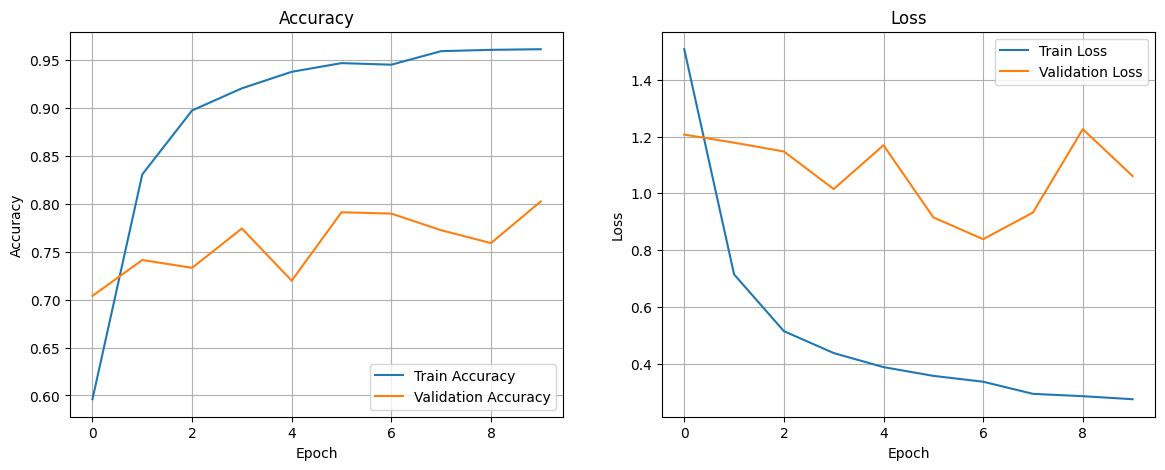

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Weighted F1-score on Validation set: 0.7788


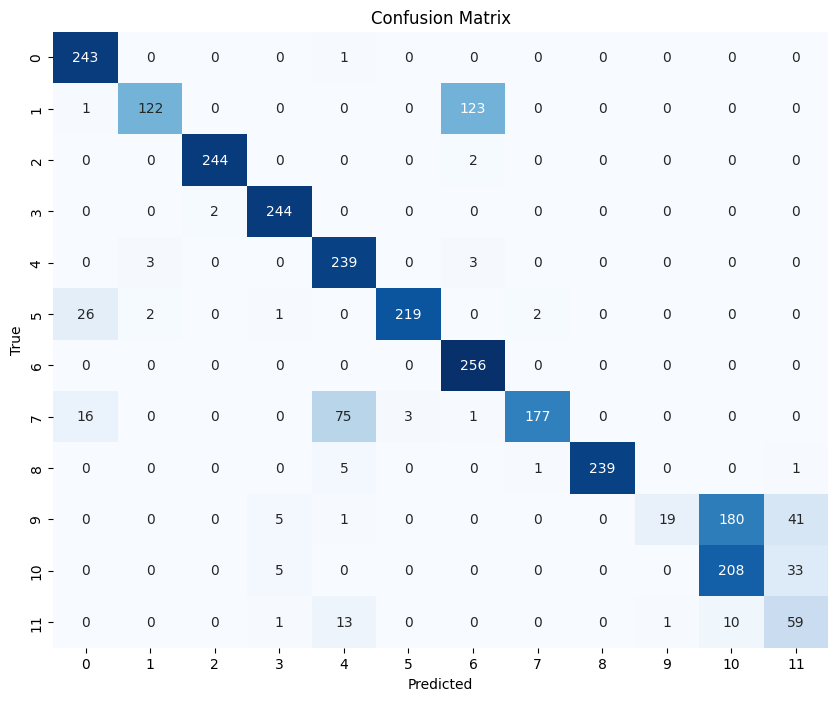

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Classification Report on Validation Set:

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       244
           1       0.96      0.50      0.65       246
           2       0.99      0.99      0.99       246
           3       0.95      0.99      0.97       246
           4       0.72      0.98      0.83       245
           5       0.99      0.88      0.93       250
           6       0.66      1.00      0.80       256
           7       0.98      0.65      0.78       272
           8       1.00      0.97      0.99       246
           9       0.95      0.08      0.14       246
          10       0.52      0.85      0.65       246
          11       0.44      0.70      0.54        84

    accuracy                           0.80      2827
   macro avg       0.83      0.80      0.77      2827
weighted avg       0.86      0.80      0.78      2827



In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import numpy as np

# 1️⃣ Accuracy & Loss 그래프
def plot_training_history(history):
    plt.figure(figsize=(14,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.show()

plot_training_history(history)

# 2️⃣ F1-score 계산
y_val_pred_prob = model.predict(X_val)
y_val_pred = np.argmax(y_val_pred_prob, axis=1)
y_val_true = np.argmax(y_val, axis=1)

f1 = f1_score(y_val_true, y_val_pred, average='weighted')
print(f"Weighted F1-score on Validation set: {f1:.4f}")

# 3️⃣ Confusion matrix 시각화
cm = confusion_matrix(y_val_true, y_val_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
y_val_pred_prob = model.predict(X_val)
y_val_pred = np.argmax(y_val_pred_prob, axis=1)
y_val_true = np.argmax(y_val, axis=1)

report = classification_report(y_val_true, y_val_pred)
print("Classification Report on Validation Set:\n")
print(report)